In [56]:
from duckduckgo_search import DDGS
from fastcore.all import *

# Using lite backend and limit the number of results
from itertools import islice

ddgs = DDGS()

def search_images(term, max_images = 30):
    print(f"searching for '{term}'")
    keywords = term
    ddgs_images = ddgs.images(keywords)
    limited_images = list(islice(ddgs_images, max_images))
    return L(limited_images).itemgot('image')

character_search = search_images('itadori yuji')
len(character_search)

searching for 'itadori yuji'


30

In [57]:
cat_search[0]

'http://upload.wikimedia.org/wikipedia/commons/d/d4/Cat_March_2010-1a.jpg'

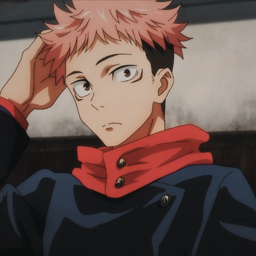

In [58]:
from fastdownload import download_url
dest = 'yuji.jpg'
download_url(character_search[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

searching for 'Kashimo Hajime photos'


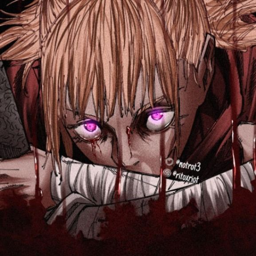

In [59]:
download_url(search_images('Kashimo Hajime photos', max_images=3)[2], 'kashi.jpg', show_progress=False)
Image.open('kashi.jpg').to_thumb(256,256)

searching for 'Yuta Okkotsu photos'


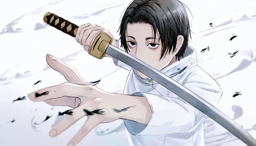

In [99]:
download_url(search_images('Yuta Okkotsu photos', max_images=3)[0], 'yuta.jpg', show_progress=False)
Image.open('yuta.jpg').to_thumb(256,256)

searching for 'jjk panda photos'


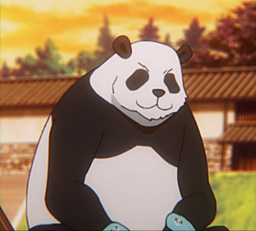

In [60]:
download_url(search_images('jjk panda photos', max_images=1)[0], 'panda.jpg', show_progress=False)
Image.open('panda.jpg').to_thumb(256,256)

In [100]:
searches = 'Yuji','Kashimo', 'Yuta'
path = Path('jjk_directory')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} culling games solo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} color photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} manga photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

searching for 'Yuji culling games solo'
searching for 'Yuji color photo'
searching for 'Yuji manga photo'
searching for 'Kashimo culling games solo'
searching for 'Kashimo color photo'
██searching for 'Kashimo manga photo'
searching for 'Yuta culling games solo'
searching for 'Yuta color photo'
searching for 'Yuta manga photo'


In [102]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
failed = failed.filter(lambda x: not str(x).endswith(('.jpg', '.jpeg')))
failed.map(Path.unlink)
len(failed)

0

In [103]:
# Convert 'RGBA' images to 'RGB' mode and save as JPEG
for img in failed:
    if img.suffix == '.png':
        img = Image.open(img).convert('RGB')
        img.save(str(img) + '.jpeg', 'JPEG')
        img.unlink()
        print(f"Converted and saved {img.name} as 'RGB' mode JPEG")

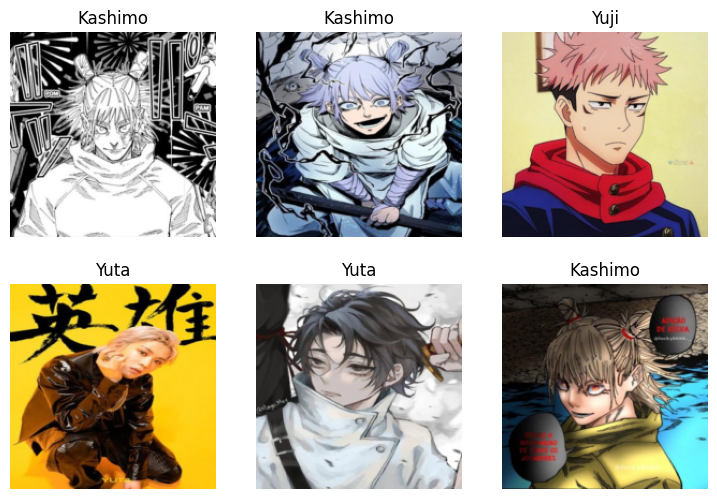

In [104]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [105]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

C:\Users\niran\anaconda3\envs\nlp-myenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\niran\anaconda3\envs\nlp-myenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch     train_loss  valid_loss  error_rate  time    
0         1.921331    1.275349    0.488372    00:30                                    
epoch     train_loss  valid_loss  error_rate  time    
0         0.935259    1.007112    0.372093    00:40                                    
1         0.645002    1.061305    0.348837    00:37                                    
2         0.508993    1.136234    0.325581    00:36                                    


In [106]:
is_yuji,_,probs = learn.predict(PILImage.create('yuji.jpg'))
print(f"This is : {is_yuji}.")
print(f"Probability it's Yuji: {probs[0]:.4f}")

This is : Yuji.                                                      
Probability it's Yuji: 0.0000


In [107]:
learn.export('model.pkl')

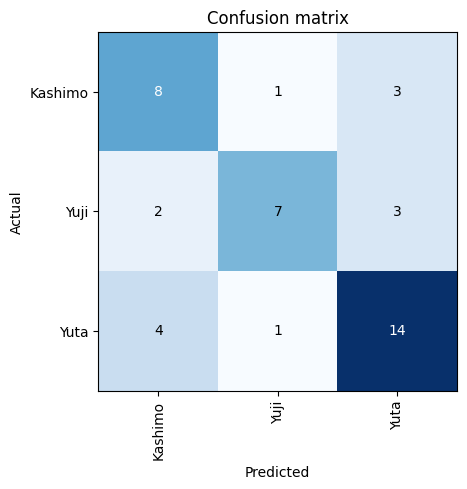

In [108]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

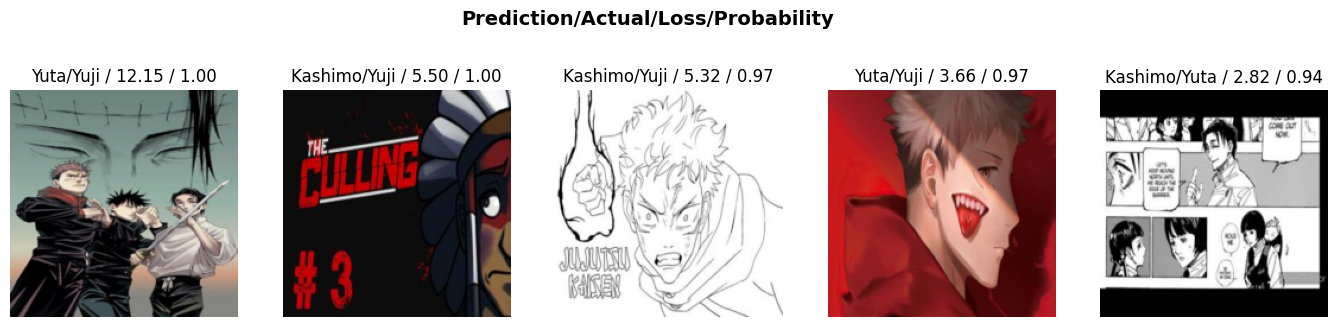

In [109]:
interp.plot_top_losses(5, nrows=1, figsize=(17,4))